In [1]:
# min: x1^2 + x2^2 + x3^2
# constraints: 2x1 + x2 + x3 <= 8
# constraints: -x1 - 2x2 + x3 <= b 
# constraints: -x1, -x2, -x3 <= 0

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
import torch.optim as optim
import random
import math
import numpy as np
from scipy.optimize import linprog
from scipy.integrate import solve_ivp

In [3]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:

def ODE_sol(b1, b2):
    
    def kkt_ode(t, y):


        x1, x2, x3, lambda1, lambda2, lambda3, lambda4, lambda5 = y
        dx1dt = -(2 * x1 + 2 * lambda1 - lambda2 - lambda3)
        dx2dt = -(2 * x2 + lambda1 - 2 * lambda2 - lambda4)
        dx3dt = -(2 * x3 + lambda1 + lambda2 - lambda5)

        dlambda1dt = lambda1 * (2 * x1 + x2 + x3 - b1)
        dlambda2dt = lambda2 * (-x1 -2 * x2 + x3 - b2)
        dlambda3dt = lambda3 * (-x1)
        dlambda4dt = lambda4 * (-x2)
        dlambda5dt = lambda5 * (-x3)

        return [dx1dt, dx2dt, dx3dt, dlambda1dt, dlambda2dt, dlambda3dt, dlambda4dt, dlambda5dt]

    # Initial conditions
    x1_0 = 0
    x2_0 = 0
    x3_0 = 0

    lambda1_0 = 0.5
    lambda2_0 = 0.5
    lambda3_0 = 0.5
    lambda4_0 = 0.5
    lambda5_0 = 0.5

    y0 = [x1_0, x2_0, x3_0, lambda1_0, lambda2_0, lambda3_0, lambda4_0, lambda5_0]

    # Time span for the solution
    t_span = (0, 20)
    t_eval = np.linspace(t_span[0], t_span[1], 201)

    # Solve the ODE system
    sol = solve_ivp(kkt_ode, t_span, y0, t_eval=t_eval)
    
    return sol

  

In [5]:
def ODE(train_data):
  
  
    b1 = []
    b2 = []
    answer=[]
    time = []
    
    for i in range(0,40200,201): 
        b1.append(train_data[i][0])
        b2.append(train_data[i][1])

    for i in range(201):
        time.append(i/10)
    

    for i in range(200): 
        
        solution = ODE_sol(b1[i], b2[i])
        for j in range(201):
            
        
            time_index = np.argmin(np.abs(solution.t - time[j]))
            x1_at_time = solution.y[0][time_index] 
            x2_at_time = solution.y[1][time_index] 
            x3_at_time = solution.y[2][time_index] 
            lambda1_at_time = solution.y[3][time_index] 
            lambda2_at_time = solution.y[4][time_index] 
            lambda3_at_time = solution.y[5][time_index] 
            lambda4_at_time = solution.y[6][time_index] 
            lambda5_at_time = solution.y[7][time_index] 
            
            
           
            answer.append([x1_at_time, x2_at_time, x3_at_time, lambda1_at_time, lambda2_at_time, lambda3_at_time, lambda4_at_time, lambda5_at_time])

        
    tensor_answer = torch.tensor(answer)
    tensor_answer = tensor_answer.float()
  
    return tensor_answer



#print(ODE(train_data))

In [6]:
# Dataset
def generate_data():
    tensor_list = []
    for i in range(1, 201):
        b1 = 8
        b2 = random.uniform(-10, 0)
        
        for j in range(201):   
            tensor_list.append([b1, b2, j/10])
            
    return tensor_list

train_data = generate_data()
test_data = generate_data()

train_data = torch.tensor(train_data)
test_data = torch.tensor(test_data)

train_label = ODE(train_data)
test_label = ODE(test_data)

    


In [7]:
train_data = torch.Tensor(train_data)
train_label = torch.Tensor(train_label)

train = TensorDataset(train_data, train_label)
train_dataload = DataLoader(train, batch_size=201, shuffle=False)


test_data = torch.Tensor(test_data)
test_label = torch.Tensor(test_label)

test = TensorDataset(test_data, test_label)
test_dataload = DataLoader(test, batch_size=201, shuffle=False)

In [8]:
class MLP(nn.Module):
    
    def __init__(self):
        super(MLP,self).__init__()
        
        self.linear1=torch.nn.Linear(3, 100)
        self.act = torch.nn.Tanh()
        self.linear2=torch.nn.Linear(100, 8)

    def forward(self, x):
        x=self.linear1(x)
        x=self.act(x)
        x=self.linear2(x)
                
        return x

In [9]:
## DeepConvNet Training
model=MLP()
model.to(device)
model = torch.load('trained_ODEs_model.pt')

optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_function = torch.nn.MSELoss()

for epoch in range(100000):
    
    train_loss = 0.0
    correct = 0
    
    for i, (data, label) in enumerate(train_dataload):
  
        data = data.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        output = model(data)

        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    if((epoch+1)%10==0):
        print("-------{}th epoch-------".format(epoch+1))
        print("Training Loss: ")
        print(train_loss)
        torch.save(model, 'trained_ODEs_model.pt')

        
        


-------10th epoch-------
Training Loss: 
0.0030505421752877737
-------20th epoch-------
Training Loss: 
0.003041256771666667
-------30th epoch-------
Training Loss: 
0.0030363493715412915
-------40th epoch-------
Training Loss: 
0.0030321343087962305


KeyboardInterrupt: 

In [23]:
device=torch.device('cpu')
model = torch.load('trained_ODEs_model.pt')
model.to(device)
model.eval()

t=20.
test = torch.tensor([8, -5, t]) # b1=8, b2=-5
test.to(device)
output = model(test)

factor = 1 - np.exp(-t)
output = [factor * x.item() for x in output]

print("For b2 = -5, the optimal solution is :", output)

For b2 = -5, the optimal solution is : [1.0027877071692455, 2.0013353783364884, 0.00017346814239033455, 7.489323600591186e-05, 2.00232314650767, -0.0009934157112626593, -0.0013237073990241077, 1.9998645741250423]


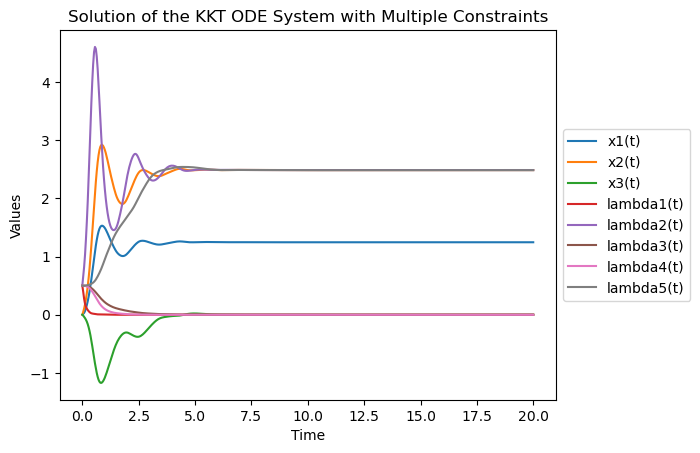

In [25]:
import matplotlib.pyplot as plt

time = []
result = np.zeros((8, 501))
device=torch.device('cpu')
model = torch.load('trained_ODEs_model.pt')
model.to(device)
model.eval()
for i in range(501):
    
    time.append(i/25)
    test = torch.tensor([8., -6.21, i/25])
    test.to(device)
    factor = 1 - np.exp(-(i/25))
    output = model(test)
    
    # output = [factor * x.item()  for x in output]

    for j in range(8):
        
        result[j][i] = output[j]



# Plot the results
plt.plot(time, result[0], label='x1(t)')
plt.plot(time, result[1], label='x2(t)')
plt.plot(time, result[2], label='x3(t)')

plt.plot(time, result[3], label='lambda1(t)')
plt.plot(time, result[4], label='lambda2(t)')
plt.plot(time, result[5], label='lambda3(t)')
plt.plot(time, result[6], label='lambda4(t)')
plt.plot(time, result[7], label='lambda5(t)')

plt.xlabel('Time')
plt.ylabel('Values')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Solution of the KKT ODE System with Multiple Constraints')
plt.show()


In [27]:
from scipy.optimize import minimize

# Define the objective function
def objective(x):
    return x[0]**2 + x[1]**2 + x[2]**2

# Initial guess
x0 = [0.5, 0.5, 0.5]

# Create lists to store results
sls_solutions = []
sls_objective_values = []

# Loop 10,000 times with different constraints
for i in range(10000):
    b1 = 8
    b2 = -i / 1000

    # Constraints
    constraints = [
        {'type': 'ineq', 'fun': lambda x, b1=b1: b1 - (2*x[0] + x[1] + x[2])},  # 2x1 + x2 + x3 <= b1
        {'type': 'ineq', 'fun': lambda x, b2=b2: b2 + x[0] + 2*x[1] - x[2]},   # -x1 - 2x2 + x3 <= b2
        {'type': 'ineq', 'fun': lambda x: x[0]},                               # x1 >= 0
        {'type': 'ineq', 'fun': lambda x: x[1]},                               # x2 >= 0
        {'type': 'ineq', 'fun': lambda x: x[2]}                                # x3 >= 0
    ]

    # Minimize
    result = minimize(objective, x0, constraints=constraints, method="SLSQP")

    # Store results
    sls_solutions.append(result.x)
    sls_objective_values.append(result.fun)




In [29]:
from scipy.optimize import minimize
import time

# Define the objective function
def objective(x):
    return x[0]**2 + x[1]**2 + x[2]**2

# Initial guess
x0 = [0.5, 0.5, 0.5]


start = time.time()

# Loop 10,000 times with different constraints
for i in range(10000):
    b1 = 8
    b2 = -i / 1000

    # Constraints
    constraints = [
        {'type': 'ineq', 'fun': lambda x, b1=b1: b1 - (2*x[0] + x[1] + x[2])},  # 2x1 + x2 + x3 <= b1
        {'type': 'ineq', 'fun': lambda x, b2=b2: b2 + x[0] + 2*x[1] - x[2]},   # -x1 - 2x2 + x3 <= b2
        {'type': 'ineq', 'fun': lambda x: x[0]},                               # x1 >= 0
        {'type': 'ineq', 'fun': lambda x: x[1]},                               # x2 >= 0
        {'type': 'ineq', 'fun': lambda x: x[2]}                                # x3 >= 0
    ]

    # Minimize
    result = minimize(objective, x0, constraints=constraints, method="SLSQP")

end = time.time()


In [31]:
print("SLSQP needs time for 10000 data:", end - start)

SLSQP needs time for 10000 data: 30.614420890808105


In [40]:
import numpy as np
import torch

# Initialize arrays
ode_solutions = np.zeros((10000, 3))
ode_objective_values = np.zeros(10000)

# Set device to CPU
device = torch.device('cpu')

# Load the model and set it to evaluation mode
model = torch.load('trained_ODEs_model.pt')
model.to(device)
model.eval()

# Iterate through the range and populate the arrays
for i in range(10000):
    test = torch.tensor([8., -i / 1000, 20.], device=device)
    output = model(test)
    
    # Populate ode_solutions with the model's output
    output = output.detach().numpy()
    
    # Compute and store the objective values
    ode_objective_values[i] = np.sum(output[:2] ** 2)
    
    ode_solutions[i][0] = output[0]
    ode_solutions[i][1] = output[1]
    ode_solutions[i][2] = output[2]


        

In [42]:
from scipy.optimize import minimize




device=torch.device('cpu')
model = torch.load('trained_ODEs_model.pt')
model.to(device)
model.eval()

start = time.time()
for i in range(10000):
    test = torch.tensor([8., - i/1000, 20.])
    test.to(device)
    output = model(test)

end = time.time()

print("Neural Network needs time for 10000 data:", end - start) 

Neural Network needs time for 10000 data: 0.6127550601959229


In [52]:
print("margin of error for average optimal solution: ", (np.sum((abs(ode_solutions - sls_solutions))))/30000)


margin of error for average optimal solution:  0.002559148632325765


In [56]:
print("margin of error for average objective function: ", np.sum(abs(ode_objective_values - sls_objective_values))/10000)


margin of error for average objective function:  0.009692755259928883
